# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a
HopsworksSettings initialized!


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
import importlib
from mlfs.airquality import util
importlib.reload(util)
import os

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 17, 22, 5, 18, 978674)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
# location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
# location = json.loads(location_str)
# country=location['country']
# city=location['city']
# street=location['street']
# url = location['aqicn_url']
# [country_1,street_1,city_1,url_1,csv_1,lat_1,long_1] = settings.KEY_PARAMS_1.split(',')
# [country_2,street_2,city_2,url_2,csv_2,lat_2,long_2] = settings.KEY_PARAMS_2.split(',')
# [country_3,street_3,city_3,url_3,csv_3,lat_3,long_3] = settings.KEY_PARAMS_3.split(',')
# [country_4,street_4,city_4,url_4,csv_4,lat_4,long_4] = settings.KEY_PARAMS_4.split(',')
# [country_5,street_5,city_5,url_5,csv_5,lat_5,long_5] = settings.KEY_PARAMS_5.split(',')
index = dict()
for i in range(1,6):
    location_str = secrets.get_secret(f"SENSOR_LOCATION_JSON_{i}").value
    location = json.loads(location_str)
    country=location['country']
    city=location['city']
    url = location['aqicn_url']
    street=location['street']
    csv = location['csv']
    index[f'sensor_{i}'] = dict()
    index[f'sensor_{i}']['country'] = country
    index[f'sensor_{i}']['city'] = city
    index[f'sensor_{i}']['street'] = street
    index[f'sensor_{i}']['csv'] = csv
    index[f'sensor_{i}']['url'] = url

2025-11-17 22:05:19,029 INFO: Initializing external client
2025-11-17 22:05:19,030 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-17 22:05:20,240 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-17 22:05:22,019 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286306


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()
fv = dict()
saved_model_dir = dict()
for key in index.keys():
    retrieved_model = mr.get_model(
        name=f"air_quality_xgboost_model_a_{key}",
        version=1,
    )
    
    fv[key] = retrieved_model.get_feature_view()
    
    # Download the saved model artifacts to a local directory
    saved_model_dir[key] = retrieved_model.download()

2025-11-17 22:05:26,993 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/437054 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/483100 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/436483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/536564 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/465466 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/118905 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/120425 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/105663 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/62469 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/117309 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/125883 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112491 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25567 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26962 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25811 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26688 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26187 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27052 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/24315 elapsed<00:00 remaining<?

2025-11-17 22:05:41,862 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/437054 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/483100 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/436483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/536564 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/465466 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/118905 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/120425 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/105663 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/62469 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/117309 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/125883 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112491 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25567 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26962 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25811 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26688 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26187 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27052 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/24315 elapsed<00:00 remaining<?

2025-11-17 22:05:56,139 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/437054 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/483100 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/436483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/536564 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/465466 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/118905 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/120425 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/105663 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/62469 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/117309 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/125883 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112491 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25567 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26962 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25811 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26688 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26187 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27052 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/24315 elapsed<00:00 remaining<?

2025-11-17 22:06:10,565 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/437054 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/483100 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/436483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/536564 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/465466 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/118905 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/120425 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/105663 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/62469 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/117309 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/125883 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112491 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25567 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26962 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25811 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26688 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26187 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27052 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/24315 elapsed<00:00 remaining<?

2025-11-17 22:06:24,965 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/437054 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/483100 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/436483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/536564 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/465466 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/118905 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/120425 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/105663 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/62469 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/117309 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/125883 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112491 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25567 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26962 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25811 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26688 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26187 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27052 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/24315 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = dict()
for key in saved_model_dir.keys():
    model = XGBRegressor()
    model.load_model(saved_model_dir[key] + f"/model_{key}.json")
    retrieved_xgboost_model[key] = model
# Displaying the retrieved XGBoost regressor model
# retrieved_xgboost_model

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather_a',
    version=1,
)
air_quality_fg = fs.get_feature_group(
    name='air_quality_a',
    version=1,
)
air_quality_data = air_quality_fg.read()
b = weather_fg.filter(weather_fg.date >= today).read()
batch_data = dict()
for key in index.keys():
    batch_data[key] = b[b['street'] == index[key]['street']]

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.18s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.64s) 


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [8]:
# make prediction from lagging
days = 7
current_date = air_quality_data['date'].max()
last_date = current_date + datetime.timedelta(-3) # For 3-days rolling window
lagging_data = air_quality_data[(air_quality_data['date'] <= current_date) & ((air_quality_data['date'] > last_date))]
for key in batch_data.keys():
    lagging_data = air_quality_data[(air_quality_data['date'] <= current_date) & ((air_quality_data['date'] > last_date))]
    for day in range(days):
        lagging_data_pseu = lagging_data[lagging_data['street'] == index[key]['street']]
        last_date = current_date + datetime.timedelta(-3) # For 3-days rolling window
        lagging_data = lagging_data_pseu[(lagging_data_pseu['date'] <= current_date + datetime.timedelta(day)) & (lagging_data_pseu['date'] > last_date + datetime.timedelta(day))]
        predicted_date = current_date + datetime.timedelta(day+1)
        pm25_data_3days = lagging_data[['date','pm25']]
        lagging3 = pm25_data_3days[pm25_data_3days['date'] == predicted_date + datetime.timedelta(-3)]['pm25'].values[0]
        lagging3= lagging3.astype('float32')
        lagging2 = pm25_data_3days[pm25_data_3days['date'] == predicted_date + datetime.timedelta(-2)]['pm25'].values[0]
        lagging2= lagging2.astype('float32')
        lagging1 = pm25_data_3days[pm25_data_3days['date'] == predicted_date + datetime.timedelta(-1)]['pm25'].values[0]
        lagging1= lagging1.astype('float32')
        
        new_row = {'date': predicted_date, 'pm25': 0, 'country':index[key]['country'],'city':index[key]['city'],'street':index[key]['street'],'url':index[key]['url'],'lagging1':lagging1,'lagging2':lagging2,'lagging3':lagging3}
        batch_data[key].loc[batch_data[key]['date'] == predicted_date,'lagging1'] = lagging1
        batch_data[key].loc[batch_data[key]['date'] == predicted_date,'lagging2'] = lagging2
        batch_data[key].loc[batch_data[key]['date'] == predicted_date,'lagging3'] = lagging3
        batch_data[key].loc[batch_data[key]['date'] == predicted_date,'predicted_pm25'] = retrieved_xgboost_model[key].predict(batch_data[key][batch_data[key]['date'] == predicted_date][['lagging1','lagging2','lagging3','temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
        lagging_data = pd.concat([lagging_data, pd.DataFrame([new_row])], ignore_index=True)
        lagging_data.loc[lagging_data[lagging_data['street'] == index[key]['street']]['date'] == predicted_date, 'pm25'] = batch_data[key].loc[batch_data[key]['date'] == predicted_date,'predicted_pm25'].values[0]


2025-11-17 22:06:45,512 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-11-17 22:06:45,512 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-11-17 22:06:45,530 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-11-17 22:06:45,550 WARNING: S

In [9]:
batch_data[key].set_index('date').sort_index()

,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,street,lagging1,lagging2,lagging3,predicted_pm25
date,,,,,,,,,,
2025-11-18 00:00:00+00:00,-2.65,0.0,6.409617,308.157257,Sundsvall,Bergsgatan,5.000000,33.000000,21.000000,26.900366
2025-11-19 00:00:00+00:00,-3.40,0.0,2.880000,180.000000,Sundsvall,Bergsgatan,26.900366,5.000000,33.000000,27.697990
2025-11-20 00:00:00+00:00,-4.25,0.0,9.085988,326.309906,Sundsvall,Bergsgatan,27.697990,26.900366,5.000000,18.194843
2025-11-21 00:00:00+00:00,-3.10,0.0,7.895416,294.227722,Sundsvall,Bergsgatan,18.194843,27.697990,26.900366,13.727026
2025-11-22 00:00:00+00:00,-3.50,0.0,1.297998,33.690102,Sundsvall,Bergsgatan,13.727026,18.194843,27.697990,32.526104
2025-11-23 00:00:00+00:00,0.90,0.0,8.311245,184.969650,Sundsvall,Bergsgatan,32.526104,13.727026,18.194843,33.574154
2025-11-24 00:00:00+00:00,1.85,0.1,9.885262,56.888649,Sundsvall,Bergsgatan,33.574154,32.526104,13.727026,33.149071


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [10]:
batch_data['sensor_1']

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,street,lagging1,lagging2,lagging3,predicted_pm25
1,2025-11-21 00:00:00+00:00,-8.05,0.0,9.449572,319.635529,Örnsköldsvik,Hörnettvägen,0.616452,0.757941,2.445368,1.559953
2,2025-11-24 00:00:00+00:00,1.50,0.2,11.525623,88.210129,Örnsköldsvik,Hörnettvägen,20.099413,16.693598,1.559953,14.004881
4,2025-11-19 00:00:00+00:00,-4.65,0.0,8.473393,347.735229,Örnsköldsvik,Hörnettvägen,2.445368,0.000000,4.000000,0.757941
9,2025-11-22 00:00:00+00:00,-9.75,0.0,5.959060,334.983124,Örnsköldsvik,Hörnettvägen,1.559953,0.616452,0.757941,16.693598
20,2025-11-20 00:00:00+00:00,-6.30,0.0,10.002560,329.743652,Örnsköldsvik,Hörnettvägen,0.757941,2.445368,0.000000,0.616452
22,2025-11-18 00:00:00+00:00,-3.00,0.0,6.193674,324.462250,Örnsköldsvik,Hörnettvägen,0.000000,4.000000,1.000000,2.445368
27,2025-11-23 00:00:00+00:00,-1.65,0.0,6.696387,233.746063,Örnsköldsvik,Hörnettvägen,16.693598,1.559953,0.616452,20.099413


In [11]:
for key in index.keys():
    batch_data[key]['street'] = index[key]['street']
    batch_data[key]['city'] = index[key]['city']
    batch_data[key]['country'] = index[key]['country']
    # Fill in the number of days before the date on which you made the forecast (base_date)
    batch_data[key]['days_before_forecast_day'] = range(1, len(batch_data[key])+1)
    batch_data[key] = batch_data[key].sort_values(by=['date'])

2025-11-17 22:06:46,385 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-11-17 22:06:46,387 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-11-17 22:06:46,388 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2025-11-17 22:06:46,388 WARNING: S

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-17 22:06:46,491 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



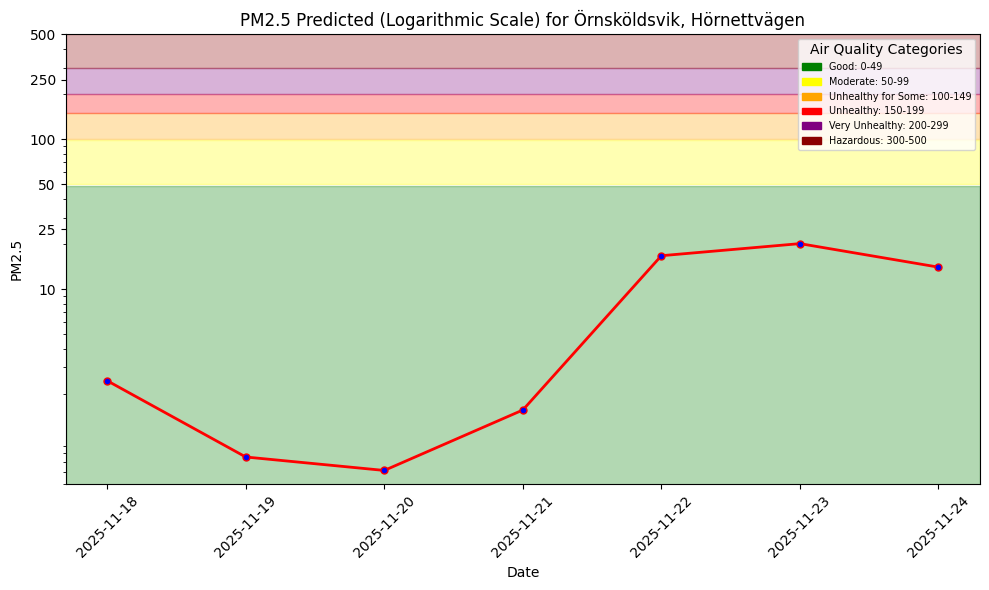

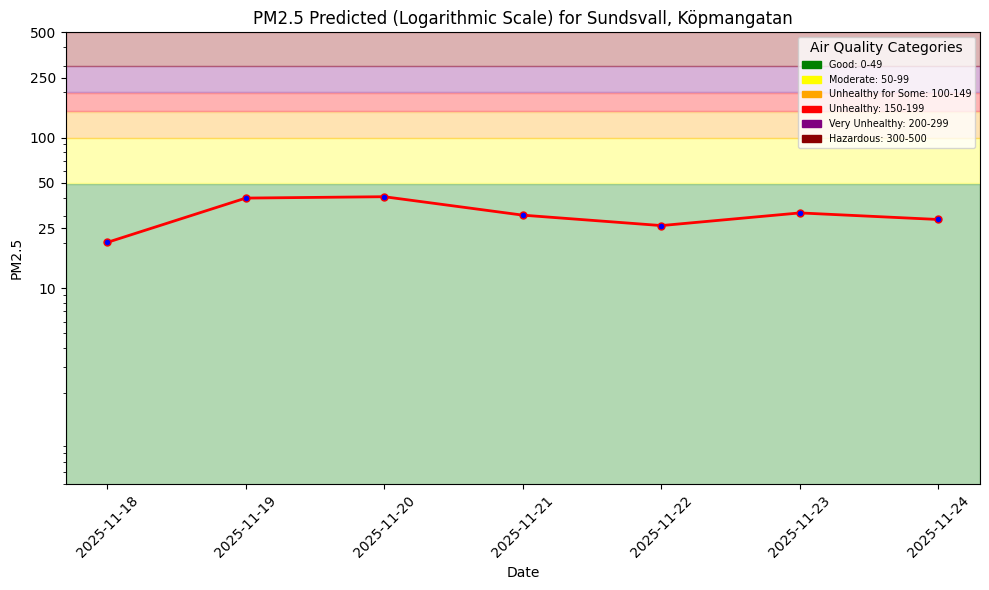

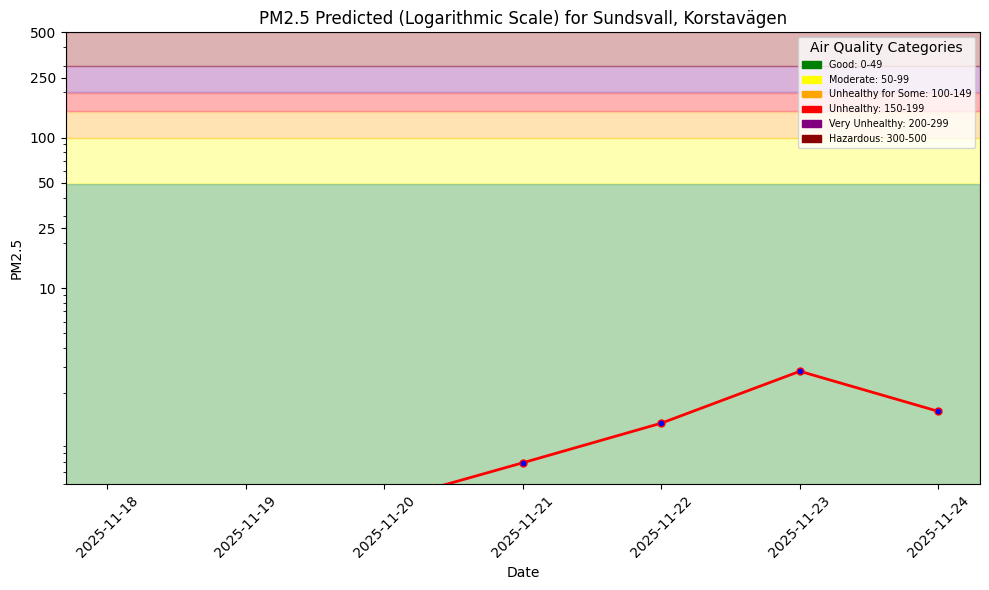

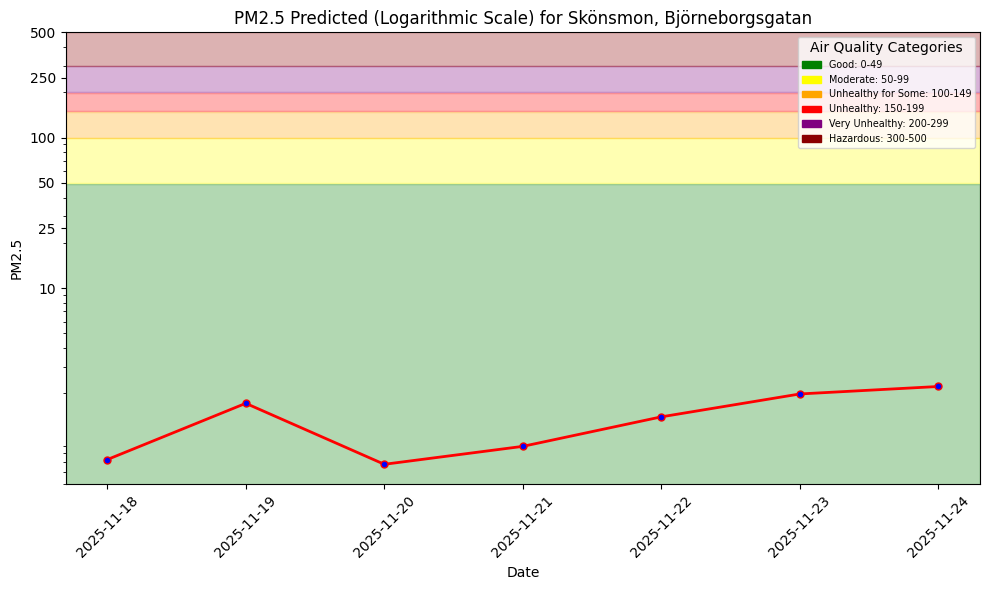

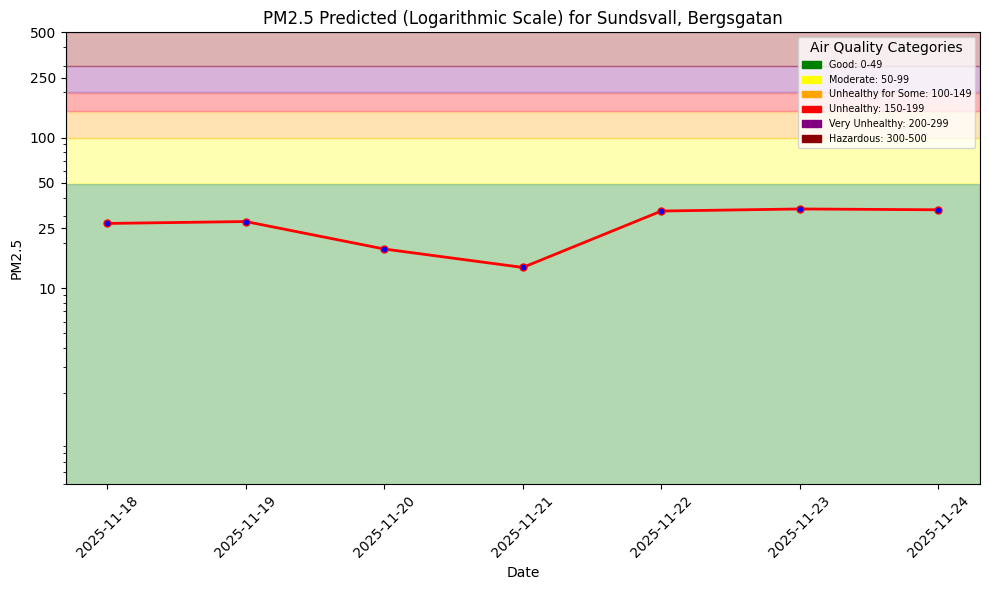

In [12]:
for key in index.keys():
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{key}.png"
    plt = util.plot_air_quality_forecast(index[key]['city'], index[key]['street'], batch_data[key], pred_file_path)
    
    plt.show()

In [13]:
b = []
for key in index.keys():
    b.append(batch_data[key])
b = pd.concat(b,axis = 0)
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_sensor',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)
monitor_fg.insert(b, wait=True)

Uploading Dataframe: 100.00% |███████████████████████████████| Rows 35/35 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_sensor_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286306/jobs/named/aq_predictions_sensor_1_offline_fg_materialization/executions
2025-11-17 22:07:06,528 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 22:07:13,020 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 22:09:27,784 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 22:09:27,961 INFO: Waiting for log aggregation to finish.
2025-11-17 22:09:46,667 INFO: Execution finished successfully.


(Job('aq_predictions_sensor_1_offline_fg_materialization', 'SPARK'), None)

In [14]:
air_quality_fg = fs.get_feature_group(name='air_quality_a', version=1)
air_quality_df = air_quality_fg.read()
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.62s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.84s) 


In [15]:
monitoring_df

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,street,lagging1,lagging2,lagging3,predicted_pm25,country,days_before_forecast_day
0,2025-11-21 00:00:00+00:00,-8.050000,0.0,9.449572,319.635529,Örnsköldsvik,Hörnettvägen,0.616452,0.757941,2.445368,1.559953,sweden,1
1,2025-11-20 00:00:00+00:00,-4.400000,0.0,9.085988,326.309906,Skönsmon,Björneborgsgatan,1.718785,0.727041,0.150000,0.676558,sweden,1
2,2025-11-21 00:00:00+00:00,-3.100000,0.0,7.895416,294.227722,Sundsvall,Korstavägen,0.381143,0.273447,0.055529,0.692724,sweden,1
3,2025-11-24 00:00:00+00:00,1.850000,0.1,9.885262,56.888649,Sundsvall,Bergsgatan,33.574154,32.526104,13.727026,33.149071,sweden,1
4,2025-11-19 00:00:00+00:00,-3.400000,0.0,2.880000,180.000000,Sundsvall,Köpmangatan,20.133722,7.000000,25.000000,39.646954,sweden,1
5,2025-11-16 00:00:00+00:00,0.136917,0.0,18.416384,299.462524,Örnsköldsvik,Hörnettvägen,6.650398,1.000000,5.000000,6.318888,sweden,1
6,2025-11-17 00:00:00+00:00,-5.850000,0.0,12.481153,326.768280,Örnsköldsvik,Hörnettvägen,6.318888,6.650398,1.000000,10.716579,sweden,1
7,2025-11-15 00:00:00+00:00,0.691083,0.2,20.327251,269.259583,Örnsköldsvik,Hörnettvägen,1.000000,5.000000,10.000000,6.650398,sweden,1
8,2025-11-16 00:00:00+00:00,0.881167,0.0,23.051247,282.668823,Sundsvall,Köpmangatan,18.339579,32.000000,18.000000,11.780775,sweden,1
9,2025-11-15 00:00:00+00:00,1.447833,0.2,22.485596,268.045349,Sundsvall,Köpmangatan,32.000000,18.000000,7.000000,18.339579,sweden,1


In [16]:
import importlib
from mlfs.airquality import util
importlib.reload(util)
hindcast_df = dict()
for key in index.keys():
    outcome_df = air_quality_df[air_quality_df['street'] == index[key]['street']][['date', 'pm25']]
    preds_df =  monitoring_df[monitoring_df['street'] == index[key]['street']][['date', 'predicted_pm25']]
    
    hindcast_df[key] = pd.merge(preds_df, outcome_df, on="date")
    hindcast_df[key] = hindcast_df[key].sort_values(by=['date'])
    
    # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
    if len(hindcast_df[key]) == 0:
        hindcast_df[key] = util.backfill_predictions_for_monitoring_predicted(weather_fg, air_quality_df[air_quality_df['street'] == index[key]['street']], monitor_fg, retrieved_xgboost_model[key],index[key]['country'],index[key]['city'],index[key]['street'],index[key]['url'])

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

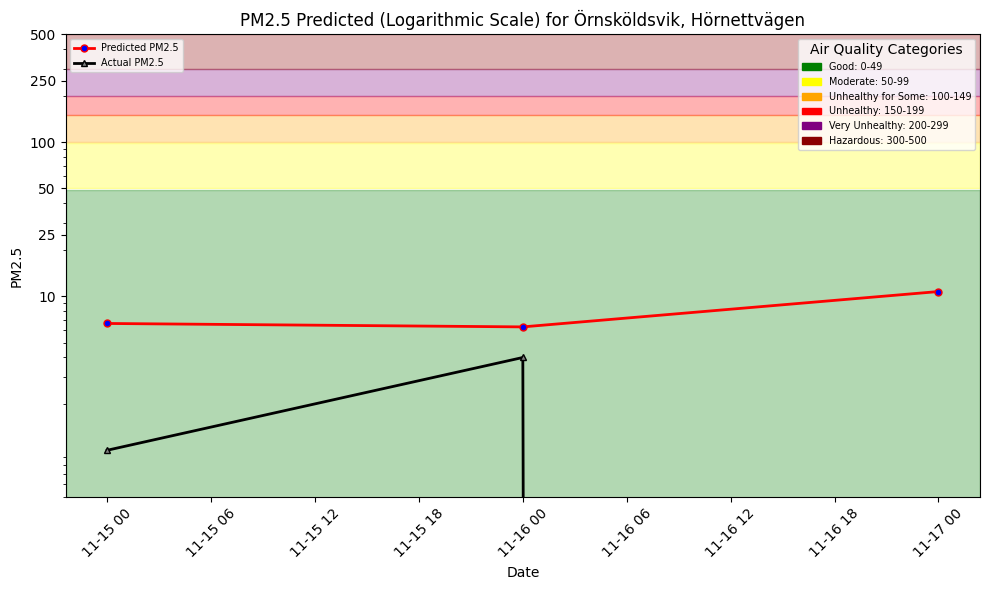

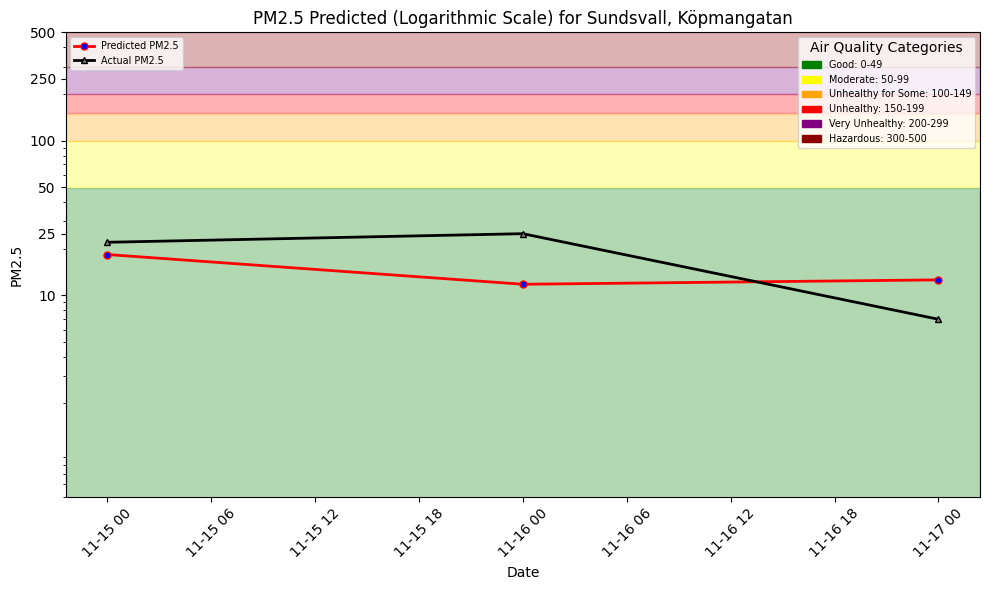

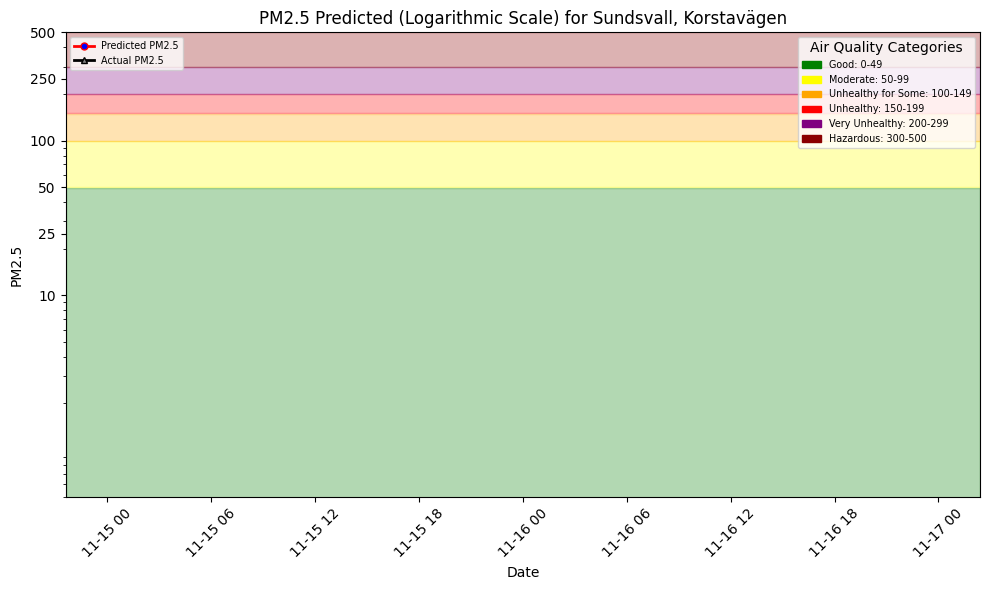

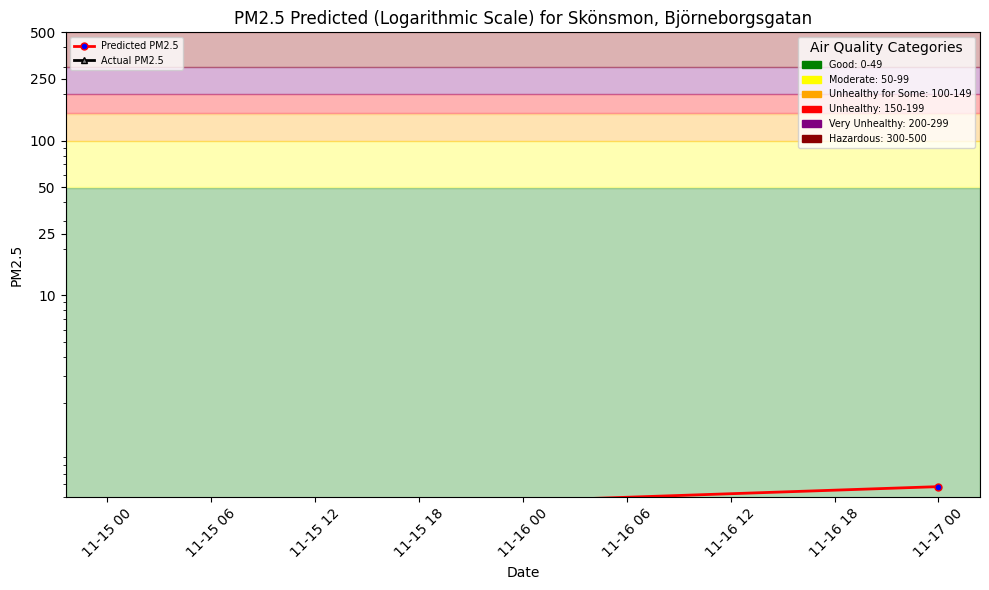

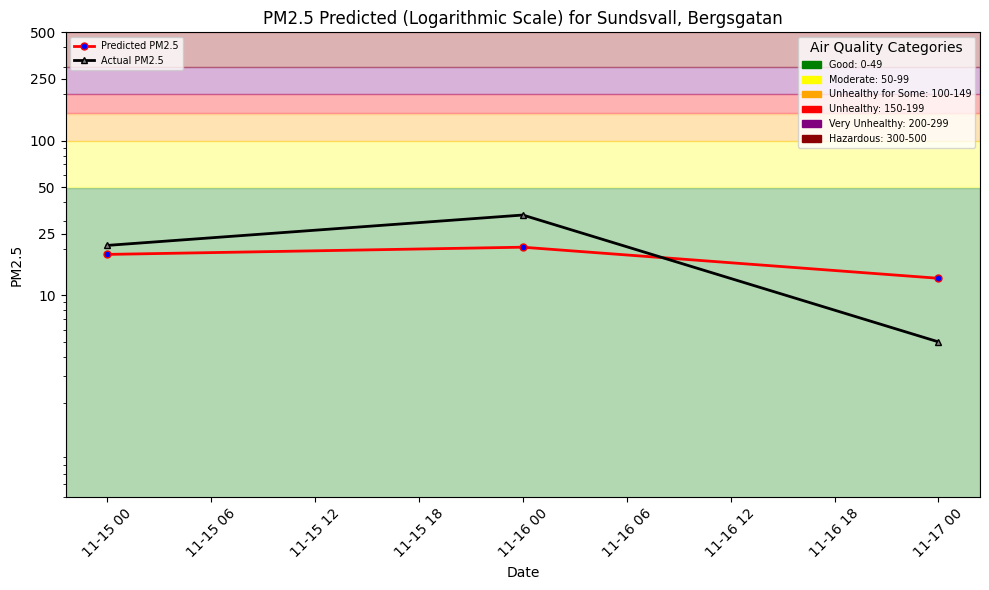

In [17]:
for key in index.keys():
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{key}.png"
    plt = util.plot_air_quality_forecast(index[key]['city'], index[key]['street'], hindcast_df[key], hindcast_file_path, hindcast=True)
    plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [18]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a/docs/air-quality/assets/img/pm25_forecast_sensor_5.…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a/docs/air-quality/assets/img/pm25_hindcast_1day_sens…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286306/settings/fb/path/Resources/airquality


---